In [80]:
## Load packages
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

from tumorpde.models.growth import TumorInfiltraFD
from tumorpde.volume_domain import VolumeDomain
from tumorpde.calc.loss import concentrated_logistic_loss, deriv_concentrated_logistic_loss, \
    concentrated_mse_loss, deriv_concentrated_mse_loss, \
    logistic_loss, deriv_logistic_loss, concentrate_density, deriv_concentrate_density

# Ensure the proper device is used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

In [79]:
import importlib
importlib.reload(sys.modules['tumorpde._typing'])
importlib.reload(sys.modules['tumorpde.models._base'])
importlib.reload(sys.modules['tumorpde.models.growth'])
importlib.reload(sys.modules['tumorpde.models.comp_utils'])
importlib.reload(sys.modules['tumorpde.volume_domain'])
importlib.reload(sys.modules['tumorpde.calc.loss'])

<module 'tumorpde.calc.loss' from '/home/muye/Projects/2024_01_BrainTumorDiffusion/TumorPDE/tumorpde/calc/loss.py'>

## Model


\begin{gather}
\frac{du}{dt} = \nabla \cdot (\mathbf{D} \nabla u)  + \alpha u (1 - u), \qquad \text{in}\ \Omega \\
\nabla u \cdot \vec{n} = 0, \qquad \text{in}\ \partial\Omega \\
u(x, 0) = f(x; x_0)
\end{gather}


- $\mathbf{D}(x) = D\, \mathbf{d}(x)$, $\mathbf{d}(x)$ is given to represent the underlying field
- $D$, $\alpha$, $x_0$: unknown parameters

## Data Generation

In [81]:
# define the grid of the spatial domain 
dx = 0.1
x_range = (0., 10.)
nx = int((x_range[1] - x_range[0]) / dx + 1)
x_grid = np.linspace(x_range[0], x_range[1], nx)
nx_dense = int((x_range[1] - x_range[0]) / dx / 5 + 1)
x_grid_dense = np.linspace(x_range[0], x_range[1], nx_dense)

# define a diffusivity field d(x)
def matter_density(x, backend="np"):
    if backend == "np":
        in_interval1 = np.logical_and(x >= 2., x <= 9.)
        in_interval2 = np.logical_and(x >= 4., x <= 6.)
        return np.zeros_like(x) + 0.1 * in_interval1 + 0.9 * in_interval2
    elif backend == "torch":
        in_interval1 = torch.logical_and(x >= 2., x <= 9.)
        in_interval2 = torch.logical_and(x >= 4., x <= 6.)
        return torch.zeros_like(x) + 0.1 * in_interval1 + 0.9 * in_interval2
    

"""
Here, vox is a 1D array representing the diffusivity field
We wrap vox by VolumeDomain such that our programn can understand it
In general, VolumeDomain is used to construct the diffusivity field 
from an arbitrary array, the vox can be 1D, 2D (images), or 3D (voxels data)
"""
vox = matter_density(x_grid)
geom = VolumeDomain(vox, voxel_widths=[dx])
t0, t1 = (0., 1.)

In [91]:
# randomly set up the parameters
alpha = 10.
D = 1.2
cx = [6.]  # center of the initial peak
# define the peak shape.
# The peak should be small enough, but if it is too small,
# the numerical solution may not be stable.
init_peak_height = 0.01
init_peak_width = 0.1
init_density_params = {'w': init_peak_width, 'h': init_peak_height, 'rmax': 3.*dx}
loss_params = {'thresh': 0.8, 'capacity': 1., 'order': 2.}

# create the PDE model
pde = TumorInfiltraFD(
    geom, D, alpha,
    init_learnable_params=cx,
    init_other_params=init_density_params,
    loss_func=concentrated_logistic_loss,
    loss_other_params=loss_params,
    loss_deriv=deriv_concentrated_logistic_loss,
    )

Forward Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 3156.23it/s]


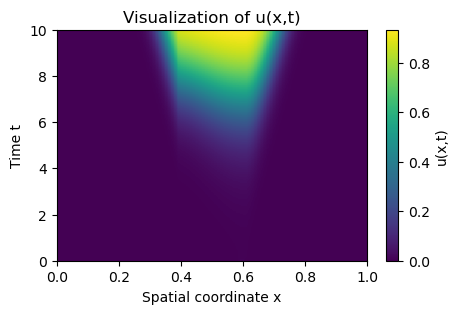

In [92]:
# do a forward run and visualize the solution

u, t, u_hist = pde.solve(dt=0.001, t1=t1, save_all=True)
U = u_hist[-1].clone()  # use the last time step as our observation

def visualize_u(U, t0, t1, x0, x1):
    # Create the heatmap
    plt.figure(figsize=(5, 3))
    plt.imshow(U, extent=(t0, t1, x0, x1), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('Spatial coordinate x')
    plt.ylabel('Time t')
    plt.title('Visualization of u(x,t)')
    plt.show()

visualize_u(u_hist[::10], t.min(), t.max(), x_range[0], x_range[1])

## Solve by Sensitivity Equations

### Single Observation

In [93]:
# use the last time step as our observation
# randomly initialize the parameters
# then calibrate the model

cx_pert = 3. + 5. * np.random.rand(1)
D_pert = D * (0.5 + np.random.rand(1))
alpha_pert = alpha * (0.5 + np.random.rand(1))
pde = TumorInfiltraFD(
    geom, D_pert, alpha_pert,
    init_learnable_params=cx_pert,
    init_other_params=init_density_params,
    # loss_func=logistic_loss,
    # loss_deriv=deriv_logistic_loss,
    loss_func=concentrated_mse_loss,
    loss_other_params=loss_params,
    loss_deriv=deriv_concentrated_mse_loss,
    )

pde.parameters


tensor([1.3611, 6.1051, 4.5766])

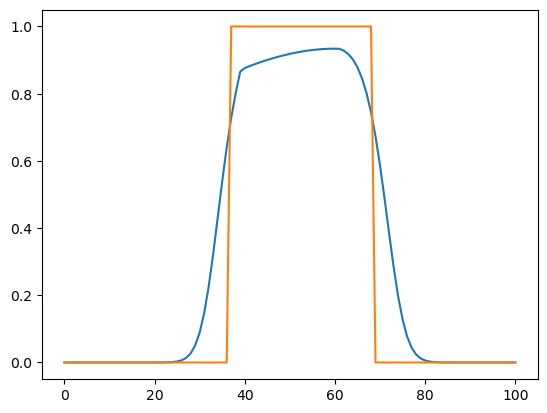

In [94]:
U_bin = (U > 0.7) * 1.
plt.plot(U.detach().cpu().numpy())
plt.plot(U_bin.detach().cpu().numpy())
plt.show()


In [95]:
result = pde.calibrate_model(
    obs=U_bin.to(device), dt=0.001, t1=t1, max_iter=100,
    verbose=True, message_period=1,
    method='L-BFGS-B')

loss: 0.14520885050296783,
params: [1.3610941171646118, 6.105114459991455, 4.576622486114502],
grads: [ 0.00243695 -0.12374856 -0.01197637]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45209D-01    |proj g|=  1.23749D-01
loss: 0.12083093076944351,
params: [1.3577772378921509, 6.860613822937012, 4.6975836753845215],
grads: [ 0.00427151 -0.27103478 -0.03414623]

At iterate    1    f=  1.20831D-01    |proj g|=  2.71035D-01
  ys=-1.850E-02  -gs= 1.546E-02 BFGS update SKIPPED
loss: 0.0328119657933712,
params: [1.3519632816314697, 8.515312194824219, 5.042460918426514],
grads: [-0.00306702 -0.22161783 -0.10816231]

At iterate    2    f=  3.28120D-02    |proj g|=  2.21618D-01
loss: 0.15841583907604218,
params: [1.3716295957565308, 26.704370498657227, 16.419721603393555],
grads: [0. 0. 0.]
loss: 0.22773060202598572,
params: [1.356925129890442, 13.10

In [88]:
print(f"True parameters: D={D}, alpha={alpha}, cx={cx}")
print(f"Estimated parameters: D={pde.D:.3f}",
      f"alpha={pde.alpha:.3f}", f"cx={[round(x.item(), 3) for x in pde.init_params.detach()]}")

True parameters: D=1.2, alpha=10.0, cx=[6.0]
Estimated parameters: D=2.227 alpha=8.939 cx=[6.091]


In [90]:
Unew, _, _ = pde.solve(dt=0.001, t1=t1, save_all=True)

Forward Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 4261.84it/s]


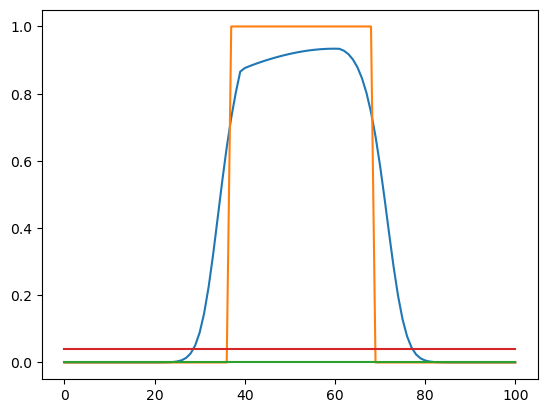

In [ ]:
plt.plot(U.detach().cpu().numpy())
plt.plot(U_bin.detach().cpu().numpy())
plt.plot(Unew.detach().cpu().numpy())
plt.plot(concentrate_density(Unew, ).detach().cpu().numpy())
plt.show()

### Multiple Observations

In [58]:
t_idx_selected = [int(( t.shape[0]-1 ) * 0.7), int(( t.shape[0]-1 ) * 1.)]
t_selected = [t[i] for i in t_idx_selected]
u_selected = u_hist[t_idx_selected]
print(f"Chosen time points: {t_selected}")

Chosen time points: [tensor(0.7000), tensor(1.)]


In [ ]:
pde = TumorInfiltraFD(
    geom, D * (0.5 + np.random.rand(1)), alpha * (0.5 + np.random.rand(1)),
    init_learnable_params=cx,
    init_other_params=init_density_params, device=device)

In [ ]:
result = pde.calibrate_model_multiscan(
    obs=u_selected, dt=0.001, t1=t1, max_iter=30,
    prepare_stage=True, max_iter_prepare=10,
    verbose=True, message_period=1)


print(f"True parameters: D={D}, alpha={alpha}, cx={cx}, t={t_selected[-1]}")
print(f"Estimated parameters: D={result['D']:.3f}",
      f"alpha={result['alpha']:.3f}", f"cx={[round(x.item(), 3) for x in result['x0'].detach()]}",
      f"t={[round(t, 3) for t in result['t_scan']]}")

Stage 0: fit the last scan
loss: 0.034580670297145844,
params: [1.359497308731079, 14.049888610839844, 6.000000476837158],
grads: [0.06032862 0.16490507 0.08017736]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45807D-02    |proj g|=  1.64905D-01
loss: 0.010795378126204014,
params: [1.2774807214736938, 11.732990264892578, 5.190208911895752],
grads: [ 0.0230453   0.09784711 -0.08773247]

At iterate    1    f=  1.07954D-02    |proj g|=  9.78471D-02
loss: 0.009581584483385086,
params: [1.1865944862365723, 8.630128860473633, 5.599861145019531],
grads: [-0.01187871 -0.20380484 -0.0359777 ]
loss: 0.003181194420903921,
params: [1.2433171272277832, 10.566645622253418, 5.344194412231445],
grads: [ 0.00644291  0.0408379  -0.07596456]

At iterate    2    f=  3.18119D-03    |proj g|=  7.59646D-02
loss: 0.0005473428755067289,
params: [1.2191554307937622,